#Cartpole balancing task in Anomalous gym using Genetic Algorithm

In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1


In [ ]:
!git clone http://github.com/modanesh/anomalous_rl_envs.git
%cd anomalous_rl_envs/gym
%pip install -e .

fatal: destination path 'anomalous_rl_envs' already exists and is not an empty directory.
/content/anomalous_rl_envs/gym
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/anomalous_rl_envs/gym
  Attempting uninstall: anomalous-gym
    Found existing installation: anomalous-gym 0.1.1
    Can't uninstall 'anomalous-gym'. No files were found to uninstall.
  Running setup.py develop for anomalous-gym


In [ ]:
!pip install box2d-py
!pip install gym[Box_2D]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gym[classic_control]
!pip install pyglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import Box2D
import random
import anomalous_gym
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from statistics import mean, median
from collections import Counter
env = gym.make('CartPoleMod-v1')
env.when_anomaly_starts = 100
env.reset()
#Number of frames
goal_steps = 1000
score_requirement = 150
initial_games = 10000000

Creating Trainig Data (observations and actions)

In [ ]:
def create_data():
    training_data, scores, accepted_scores = [], [], []
    with tqdm.trange(initial_games) as t:
      for j in t:
        score = 0
        #Moves from current environment and previous observations
        game_memory, prev_observation = [], []
        for i in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
        t.set_description(f'Episode {j}')
        t.set_postfix(episode_reward=scores[j])
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
        
    return training_data

Population Initialization

In [ ]:

def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -2.0, high = 2.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop
   

Fitness function

In [ ]:
def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
    return fitness

Selection

In [ ]:
def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

Crossover

In [ ]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings    

Mutation

In [ ]:

def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants

Prediction utility functions

In [ ]:

def sigmoid(z):
    return 1/(1+np.exp(-z))

def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

GA Model training loop

In [ ]:
def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    
    weights = []
    fitness_history=[]
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 5000
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        fitness_history.append(fitness)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights, fitness_history



training_data = create_data()
weights,fitness_history  = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)
weight1=weights

Episode 99999: 100%|██████████| 100000/100000 [08:26<00:00, 197.52it/s, episode_reward=15]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


Average accepted score: 170.5
Median accepted score: 170.5
Initial Population:
[[-1.65890952  1.61912871 -0.7561706  -1.50560466]
 [ 0.95010008  1.60784837 -1.26410781  0.05812839]
 [ 0.35828021  1.50859837  0.73692101  0.63768254]
 [-0.28619831  1.80790187 -1.26261519 -1.84888885]
 [ 1.55028064  0.83170795  1.52234867 -1.58412542]
 [ 1.28862296 -0.00251605 -0.5283734  -1.23517577]
 [ 0.3769668   0.79173949  0.55282359  0.67968956]
 [ 1.09387487  1.89197933  1.78608044 -1.56736851]]
Weights: [array([222.10930385,  38.66372052, 134.26871506, 305.13192678])]


Data Visualization

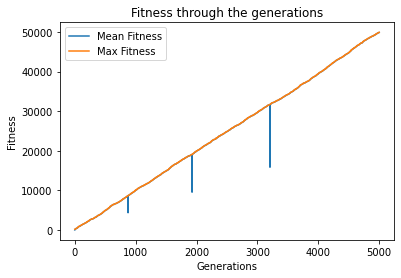

In [ ]:
num_generations = 5000
weight1=weights
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

Rendering model performace in environment

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display
from tensorflow.keras import Model
import tensorflow as tf
display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  #state = tf.constant(env.reset(), dtype=tf.float32)
  state=env.reset()
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action = GA_model_predict(state, weights)
    state, _, done, _ = env.step(action)
    #state = tf.constant(state, dtype=tf.float32)

    # Render screen every 1 step
    if i % 1 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, 1000)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until



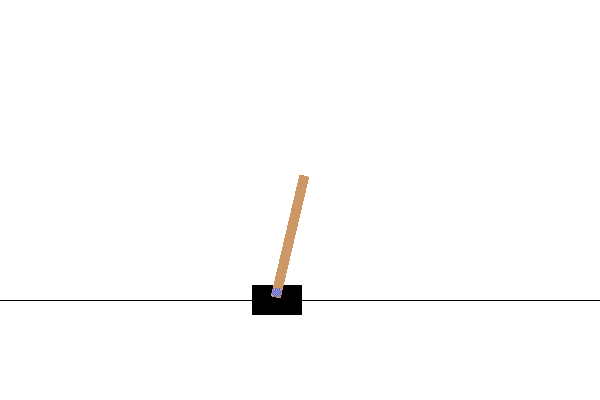

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)